In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import time
import sys, os

os.environ["TMP"] = "/disk/scratch/mhennig/tmp"
os.environ["TMPDIR"] = "/disk/scratch/mhennig/tmp"
os.environ["TEMPDIR"] = "/disk/scratch/mhennig/tmp"

os.environ["KILOSORT2_PATH"] = "/disk/scratch/mhennig/spikeinterface/Kilosort2/"
os.environ["NPY_MATLAB_PATH"] = "/disk/scratch/mhennig/spikeinterface/npy-matlab/"
os.environ["KILOSORT_PATH"] = "/disk/scratch/mhennig/spikeinterface/KiloSort/"
os.environ["IRONCLUST_PATH"] = "/disk/scratch/mhennig/spikeinterface/ironclust"

import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
# import tempfile
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy
import networkx as nx

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   

%matplotlib inline

# Load data and sorter results

In [2]:
# MEArec dataset
p = Path('/disk/scratch/mhennig/spikeinterface/paper/MEArec/')
study_folder = p / 'study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/'
mearec_filename = Path('/disk/scratch/mhennig/MEArec') / 'recordings_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28.h5'
SX_gt = se.MEArecSortingExtractor(mearec_filename)
RX = se.MEArecRecordingExtractor(mearec_filename)

In [3]:
# Load groundtruth study folder (needs an already sorted groundtruth study)
study = GroundTruthStudy(study_folder)
sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous']
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
               'SpykingCircus', 'Tridesclous']
sorter_names_short = ['HS2', 'KS2', 'IC', 'SC', 'TDC']

In [4]:
print("Spikeinterface packages:")
print("------------------------")
for p in (se,st,ss,sc,sw):
    print(p.__package__+' '+p.version.version)
print("\nSpike sorters:")
print("--------------")
for s in sorter_list:
    print(s+': '+ss.sorter_dict[s].get_sorter_version())
    
study.run_sorters(sorter_list, mode='keep', engine='loop', verbose=True)

Spikeinterface packages:
------------------------
spikeextractors 0.8.2
spiketoolkit 0.6.1
spikesorters 0.3.0
spikecomparison 0.2.3
spikewidgets 0.4.1

Spike sorters:
--------------
herdingspikes: 0.3.7
kilosort2: git-67a42a87b866
ironclust: 5.9.3
spykingcircus: 0.9.5
tridesclous: 1.5.0


CPU times: user 53.9 ms, sys: 12.3 ms, total: 66.1 ms
Wall time: 60.2 ms


Text(0.5, 0, 'GT units SNR')

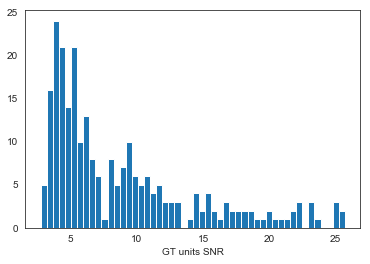

In [5]:
%%time

# compute or load SNR for GT units

snr_file = study_folder / 'snr.npy'
if os.path.isfile(snr_file):
    snr = np.load(snr_file)
else:
    print('computing snr')
    # compute from MDA for now, much faster
    rec = se.MdaRecordingExtractor('/disk/scratch/mhennig/spikeinterface/paper/MEArec/study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/sorter_folders/rec0/ironclust/ironclust_dataset')
    snr = st.validation.compute_snrs(SX_gt, rec, apply_filter=False, verbose=False, 
                                     memmap=True, max_spikes_per_unit_for_snr=500)
    np.save(snr_file, snr)

# this may be broken, seems to retyurn the same number for each unit
# snr = study.get_units_snr(max_spikes_per_unit_for_snr=500)

fig, ax = plt.subplots()
ax.hist(snr, bins=50)
ax.set_xlabel('GT units SNR')

# Perform ground truth comparison

In [6]:
study.run_comparisons(exhaustive_gt=True)
# this retrieves the comprison results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

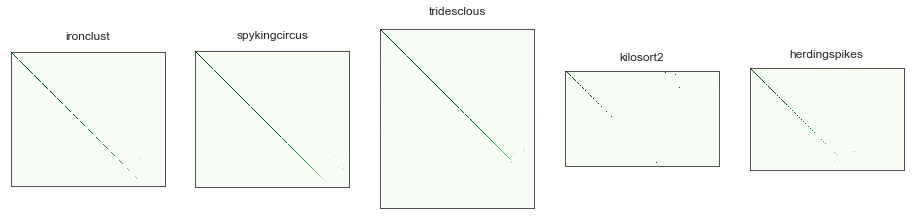

In [7]:
# confusion matrices
plt.figure(figsize=(16,4))
for i, ((rec_name, sorter_name), comp) in enumerate(comparisons.items()):
    ax = plt.subplot(1,5,i+1)
    w = sw.plot_agreement_matrix(comp, ax=ax, count_text=False, unit_ticks=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sorter_name)

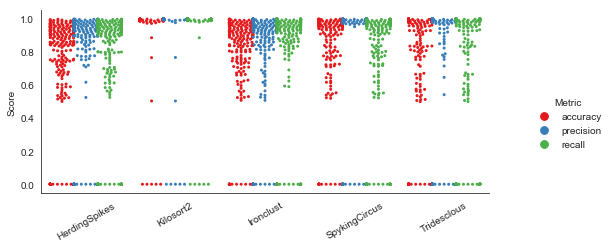

In [8]:
sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='Metric', value_name='Score', 
        value_vars=('accuracy','precision', 'recall'))
grid = sns.catplot(data=df, x='sorter_name', y='Score', hue='Metric', kind='swarm', dodge=True,
                order=sorter_list, legend_out=True, s=3)
ax = grid.fig.axes[0]
ax.set_xticklabels(sorter_names, rotation=30, ha='center')
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)
grid.fig.set_size_inches(9,3)

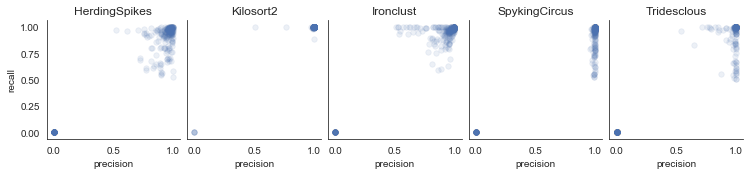

In [9]:
# fig = plt.figure(figsize=(14,4))
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], 
                x='precision', y='recall', col='sorter_name', 
                col_wrap=5, col_order=sorter_list, s=30, edgecolor=None, alpha=0.1)
g.fig.set_size_inches(10,2)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_names[i])


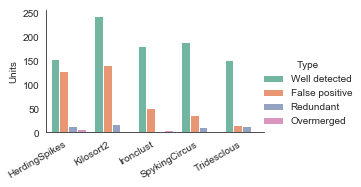

In [10]:
sns.set_palette(sns.color_palette("Set2"))
df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='Type', value_name='Units', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
grid = sns.catplot(x='sorter_name', y='Units', hue='Type', data=df,
                kind="bar", order=sorter_list)
ax = grid.axes[0,0]
ax.set_xticklabels(sorter_names, rotation=30, ha='right')
for t, l in zip(grid._legend.texts, ("Well detected", "False positive", "Redundant", "Overmerged")): t.set_text(l)
ax.set_xlabel(None);
grid.fig.set_size_inches(5,2)


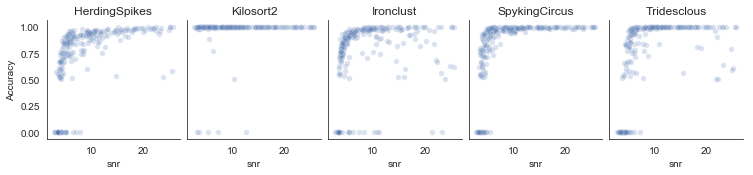

In [11]:
df = dataframes['perf_by_units']

# add snr to the by-unit table
if 'snr' not in df.keys():
    snr_d = {k:snr[k] for i,k in enumerate(SX_gt.get_unit_ids())}
    df['snr'] = df['gt_unit_id'].map(snr_d)

sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                col_wrap=5, col_order=sorter_list, s=30, alpha=0.2)
# for i,ax in enumerate(g.axes):
#     ax.set_title(sorter_list[i])
#     ax.set_xlabel('')
#     g.axes[0].set_xlabel('SNR');

g.axes[0].set_ylabel('Accuracy');
g.fig.set_size_inches(10,2)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_names[i])


# Compare multiple sorters

In [12]:
sortings = []
for s in sorter_list:
    sortings.append(study.get_sorting(s))
    
mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                               verbose=False, match_score=0.5)
mcmp_graph = mcmp.graph.copy()

# Plot agreement between sorters

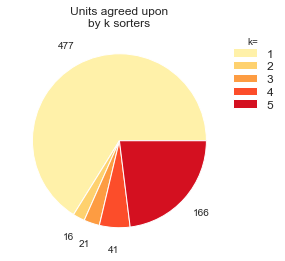

In [13]:
w = sw.plot_multicomp_agreement(mcmp, plot_type='pie')

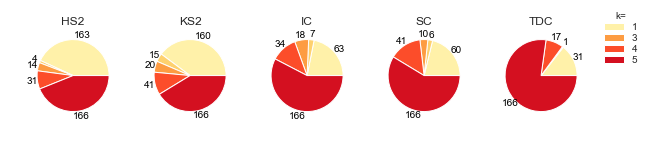

In [14]:
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

# Compare the agreement sorting to ground truth

In [15]:
# get sorting extractors with unit with no agreement (minimum agreement = 1) and one
# with at least 2 sorters in agreement
not_in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=1, minimum_agreement_count_only=True)
in_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=2)

# score these against ground truth
cmp_no_agr = sc.compare_sorter_to_ground_truth(SX_gt, not_in_agreement)
cmp_agr = sc.compare_sorter_to_ground_truth(SX_gt, in_agreement)

Text(0.5, 1.05, 'Units in agreement')

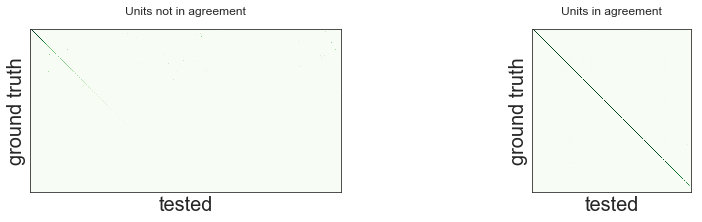

In [16]:
plt.figure(figsize=(14,3))
ax = plt.subplot(121)
sw.plot_agreement_matrix(cmp_no_agr, ax=ax, count_text=False, unit_ticks=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Units not in agreement')

ax = plt.subplot(122)
sw.plot_agreement_matrix(cmp_agr, ax=ax, count_text=False, unit_ticks=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Units in agreement')


In [17]:
print('Ground truth comparison')
print('#######################\n')
print('Units not in agreement:')
print('=======================')
cmp_no_agr.print_summary()
cmp_no_agr.print_performance()

print('Units in agreement:')
print('===================')
cmp_agr.print_summary()
cmp_agr.print_performance()

Ground truth comparison
#######################

Units not in agreement:
SUMMARY
-------
GT num_units: 250
TESTED num_units: 477
num_well_detected: 20 
num_redundant: 23
num_overmerged: 9
num_false_positive_units 362
num_bad: 451

PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 9.458736616559188
RECALL: 9.746400763225106
PRECISION: 9.998764420295489
FALSE DISCOVERY RATE: 0.4012355797045132
MISS RATE: 0.6535992367748937

Units in agreement:
SUMMARY
-------
GT num_units: 250
TESTED num_units: 244
num_well_detected: 233 
num_redundant: 0
num_overmerged: 2
num_false_positive_units 3
num_bad: 3

PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 93.27476658856268
RECALL: 96.30859171633476
PRECISION: 93.34764959940742
FALSE DISCOVERY RATE: 3.0523504005926148
MISS RATE: 0.09140828366527416



# Ground truth comparison of agreement per sorter

In [18]:
# collect results for each sorter:

# create dict to collect results
results = {'TP':{}, 'FP':{}, 'SNR':{}}
ns = len(sorter_names_short)
for s in sorter_names_short:
    results['TP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['FP'][s] = dict(zip(range(1,ns+1), [0]*(ns+1)))
    results['SNR'][s] = dict(zip(range(1,ns+1), [[]]*(ns+1)))
    
# sorter names
dict_names = dict(zip(sorter_names_short, sorter_list))

# iterate over all units gathered from subgraphs
for u in  mcmp._new_units.keys():
    found_in_gt = []
    gt_index = []
    # check if units have a match in ground truth, store boolen
    for u2 in mcmp._new_units[u]['sorter_unit_ids'].items():
        found_in_gt.append(u2[1] in study.comparisons['rec0',dict_names[u2[0]]].best_match_12.values)
        if found_in_gt[-1]:
            gt_index.append(np.where(study.comparisons['rec0',dict_names[u2[0]]].best_match_12==u2[1])[0][0])
    if len(set(gt_index))>1:
        print('different gt units: ',u, gt_index)
    if np.sum(found_in_gt)==len(found_in_gt):
#     if np.sum(found_in_gt)>0:#==len(found_in_gt):  # use this if interested in equal matches
        key = 'TP'
    else:
        key = 'FP'
        if len(found_in_gt)>1:
            print('FP unit found by >1 sorter: ',u)
        
    for i,u2 in enumerate(mcmp._new_units[u]['sorter_unit_ids'].items()):
#         results[key][u2[0]][np.sum(found_in_gt)] += 1 # use this if interested in equal matches
        results[key][u2[0]][len(found_in_gt)] += 1
        if key is 'TP':
            # something odd with nested oython dicts requires this:
            d = results['SNR'][u2[0]][len(found_in_gt)].copy()
            d.append(snr[gt_index[i]])
            results['SNR'][u2[0]][len(found_in_gt)] = d
            # this fails, I wonder why:
            # results['SNR'][u2[0]][len(found_in_gt)].append(snr[gt_index[i]])


different gt units:  13 [155, 216, 216, 216]
different gt units:  28 [146, 213, 213, 213, 213]
different gt units:  46 [224, 224, 224, 76, 224]
different gt units:  53 [90, 108, 108, 108, 108]
FP unit found by >1 sorter:  76
FP unit found by >1 sorter:  85
different gt units:  103 [136, 136, 60, 136, 136]
different gt units:  106 [153, 197, 197, 197, 153]
different gt units:  109 [18, 18, 18, 18, 5]
different gt units:  129 [129, 50, 129, 129, 129]
FP unit found by >1 sorter:  154
FP unit found by >1 sorter:  155
different gt units:  164 [196, 196, 196, 196, 179]
different gt units:  203 [185, 185, 185, 177, 177]
FP unit found by >1 sorter:  207


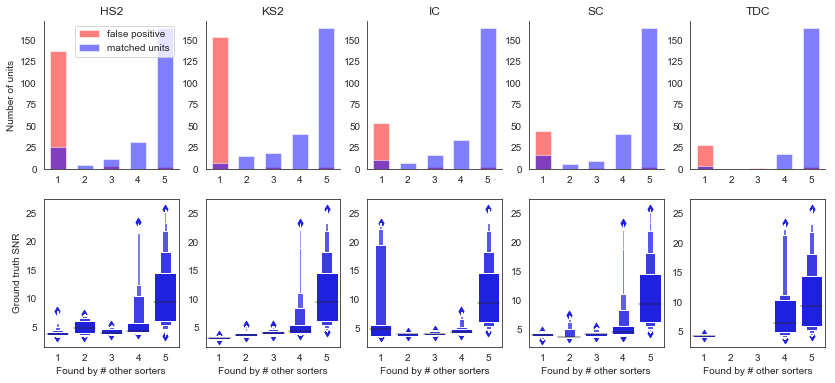

In [19]:
plt.figure(figsize=(14, 6))

for i,s in enumerate(results['TP'].keys()):
    ax = plt.subplot(2,len(sorter_list),i+1)
    
    plt.bar(results['FP'][s].keys(), results['FP'][s].values(), alpha=0.5, width = 0.6, color='r', label='false positive')
    
    plt.bar(results['TP'][s].keys(), results['TP'][s].values(), alpha=0.5, width = 0.6, color='b', label='matched units')
    plt.xticks(range(1,len(sorter_list)+1))
    if i==0:
        plt.legend()
        plt.ylabel('Number of units')
    plt.title(s)
    clear_axes(ax)
    
    ax = plt.subplot(2,len(sorter_list),i+1+len(sorter_list)) 
    d  = results['SNR'][s]
    sns.boxenplot(data=pd.DataFrame([pd.Series(d[k]) for k in d.keys()]).T, color='b', ax=ax)
    plt.xlabel('Found by # other sorters')
    plt.xticks(range(0,len(sorter_list)))
    ax.set_xticklabels(range(1,len(sorter_list)+1))
    
    if i==0:
        plt.ylabel('Ground truth SNR')
    